In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
import keras_tuner

import sklearn
from sklearn.preprocessing import RobustScaler

import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

import datetime as dt

from functools import reduce
from functions import *


# Import data
## In-situ: Mill Race

In [2]:
wt_obs = pd.read_csv(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Observational\Marine Institute\Environmental\millrace_temp_dec_2021.csv', parse_dates=['datetime'], dayfirst = True)
wt_obs.columns = ['date', 'wt'] # Rename columns
#wt_obs.wt.interpolate('linear', inplace = True) # We need to estimate the missing temperatures
wt_obs = wt_obs[(wt_obs['date'].dt.year >= 1961)&(wt_obs['date'].dt.year < 2020)].reset_index(drop = True) # Remove observations older than 1961 and newer than 2019 to match with ISIMIP datasets and reset index

Text(0.5, 0, 'Year')

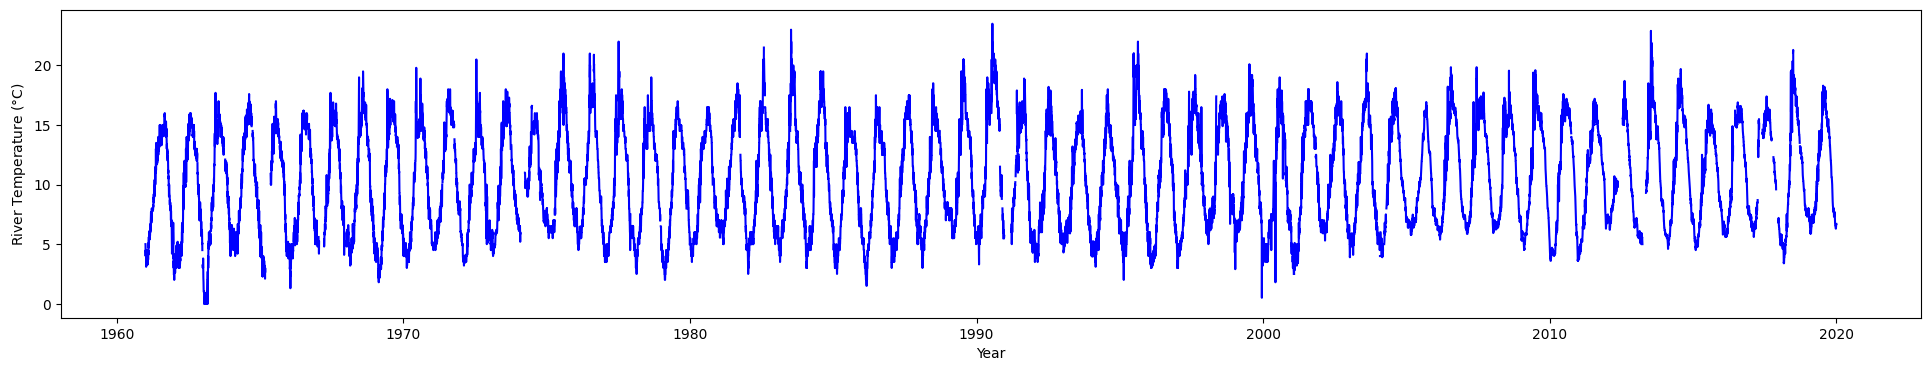

In [3]:
plt.rcParams["figure.figsize"] = (24,4)
plt.plot(wt_obs.date, wt_obs.wt, color = 'blue')
plt.ylabel(r'River Temperature ($\degree$C)')
plt.xlabel(r'Year')

In [4]:
wt_obs.set_index('date', inplace = True)
wt_obs.wt.interpolate('time', limit = 30, inplace = True)
wt_obs.reset_index(inplace = True)

Text(0.5, 0, 'Year')

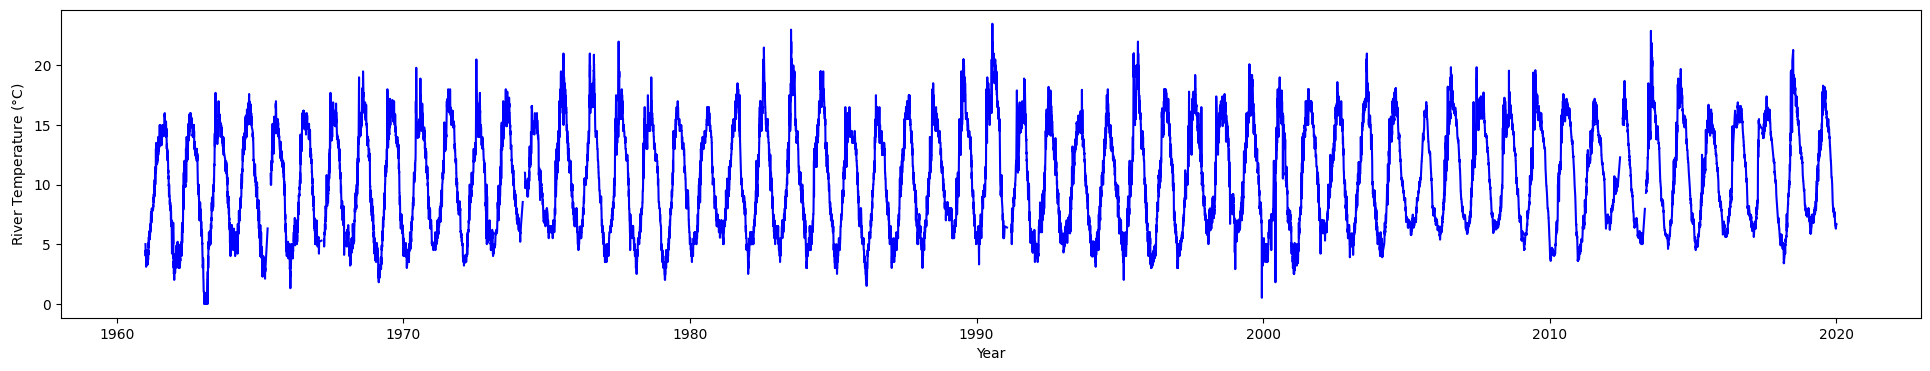

In [5]:
plt.rcParams["figure.figsize"] = (24,4)
plt.plot(wt_obs.date, wt_obs.wt, color = 'blue')
plt.ylabel(r'River Temperature ($\degree$C)')
plt.xlabel(r'Year')

In [6]:
wt_obs[wt_obs.wt.isna()].date.dt.year.unique() # Prolonged period of missing data

array([1965, 1967, 1974, 1991, 2012, 2013, 2017], dtype=int64)

In [7]:
drop_index = wt_obs[wt_obs.date.dt.year.isin(wt_obs[wt_obs.wt.isna()].date.dt.year.unique())].index # Index of all years with missing values after 30 days of interpolation
wt_obs.drop(drop_index, inplace = True)
drop_index2 = wt_obs[(wt_obs.date.dt.year == 2005)].index # Sensor error
wt_obs.drop(drop_index2, inplace = True)
drop_index3 = wt_obs[(wt_obs.date.dt.year == 1990)].index # Calibration error
wt_obs.drop(drop_index3, inplace = True)

Text(0.5, 0, 'Year')

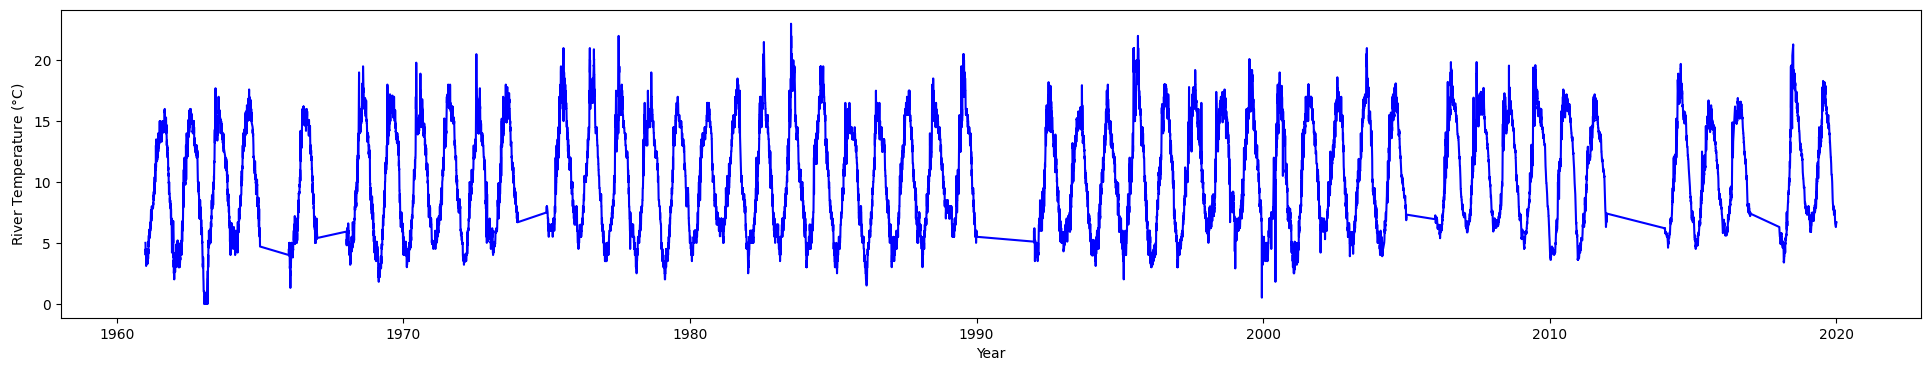

In [8]:
plt.rcParams["figure.figsize"] = (24,4)
plt.plot(wt_obs.date, wt_obs.wt, color = 'blue')
plt.ylabel(r'River Temperature ($\degree$C)')
plt.xlabel(r'Year')

In [9]:
wt_obs.set_index('date', inplace = True)
wt_obs = wt_obs[~wt_obs.index.duplicated()]
date_index = pd.date_range('1/1/1961', '12/31/2019', freq = 'D')
wt_obs = wt_obs.reindex(date_index)
wt_obs.reset_index(inplace = True)
wt_obs.columns = ['date', 'wt']

Text(0.5, 0, 'Year')

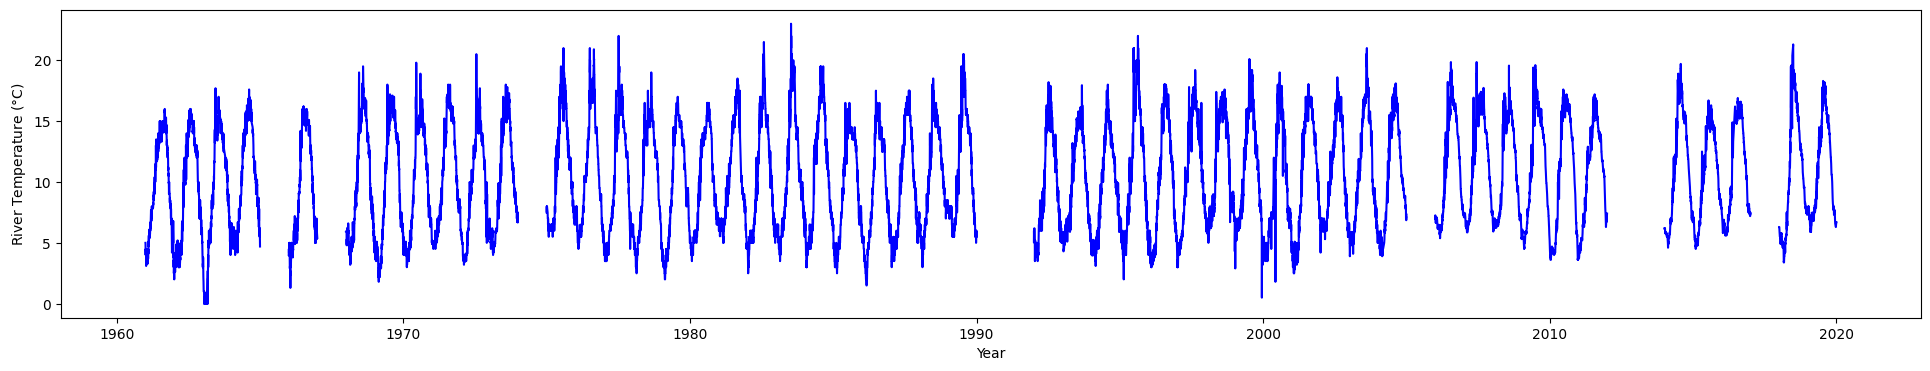

In [10]:
plt.rcParams["figure.figsize"] = (24,4)
plt.plot(wt_obs.date, wt_obs.wt, color = 'blue')
plt.ylabel(r'River Temperature ($\degree$C)')
plt.xlabel(r'Year')

The problem of missing values is intricate, and it's difficult to justify interpolation. In our case, if there are less than a month of consecutive missing values, we will interpolate them in order to retain some data. 
The remaining years are dropped from the dataset

## Atmospheric data: ISIMIP3A GSWP3-W5E5 obsclim 

In [11]:
climate_variables = ['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind'] # Store abbreviations in list
ds = pd.DataFrame() # Create dataframe to store atmospheric variables
for climate_variable in climate_variables:  # Loop through each variable in the list
    if climate_variable in ['tas', 'tasmax', 'tasmin']: # If variable is measured in kelvin convert to celsius and store in dataframe
        ds_var = read_multiple_csv(rf'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\ISIMIP3A\{climate_variable}', 'date', 'value', transform_func = kelvinToCelsius)
        ds_var['climate_variable'] = climate_variable
        ds = pd.concat([ds, ds_var])
    elif climate_variable in ['pr', 'prsn', 'sfcwind']: # If variable is measured as average per second retain possibility to convert to per hour, per day, etc. 
        ds_var = read_multiple_csv(rf'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\ISIMIP3A\{climate_variable}', 'date', 'value', transform_func = None)
        ds_var['climate_variable'] = climate_variable
        ds = pd.concat([ds, ds_var])
    elif climate_variable in ['huss', 'hurs', 'rsds', 'rlds']: # If variable is measured without any specific time denominator, or only contains per square meter (we could convert to catchment total, but refrain from that currently)
        ds_var = read_multiple_csv(rf'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\ISIMIP3A\{climate_variable}', 'date', 'value', transform_func = None)
        ds_var['climate_variable'] = climate_variable
        ds = pd.concat([ds, ds_var])

ds.reset_index(inplace = True, drop = True) # Reset the index 
ds = ds.pivot(index = 'date', columns = ['climate_variable']) # Pivot and set date to index and columns to atmospheric variables
ds = ds.droplevel(level = 0, axis = 1) # Drop multilevel axis 
ds.index = pd.to_datetime(ds.index) # Encode date index to datetime
ds.reset_index(inplace = True) # Remove date as index, and number it

Text(0.5, 0, 'Year')

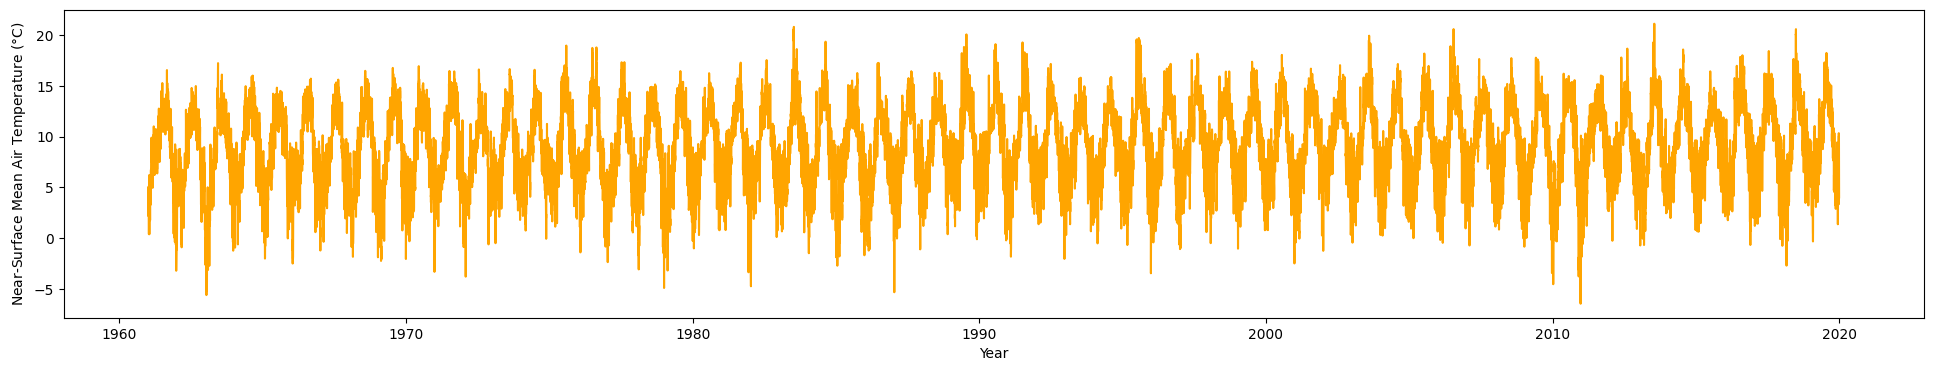

In [12]:
plt.plot(ds.date, ds.tas, color = 'orange')
plt.ylabel(r'Near-Surface Mean Air Temperature ($\degree$C)')
plt.xlabel('Year')

## Merge the data

In [13]:
df = pd.merge(wt_obs, ds, on = 'date', how = 'inner')

Text(0.5, 0, 'Year')

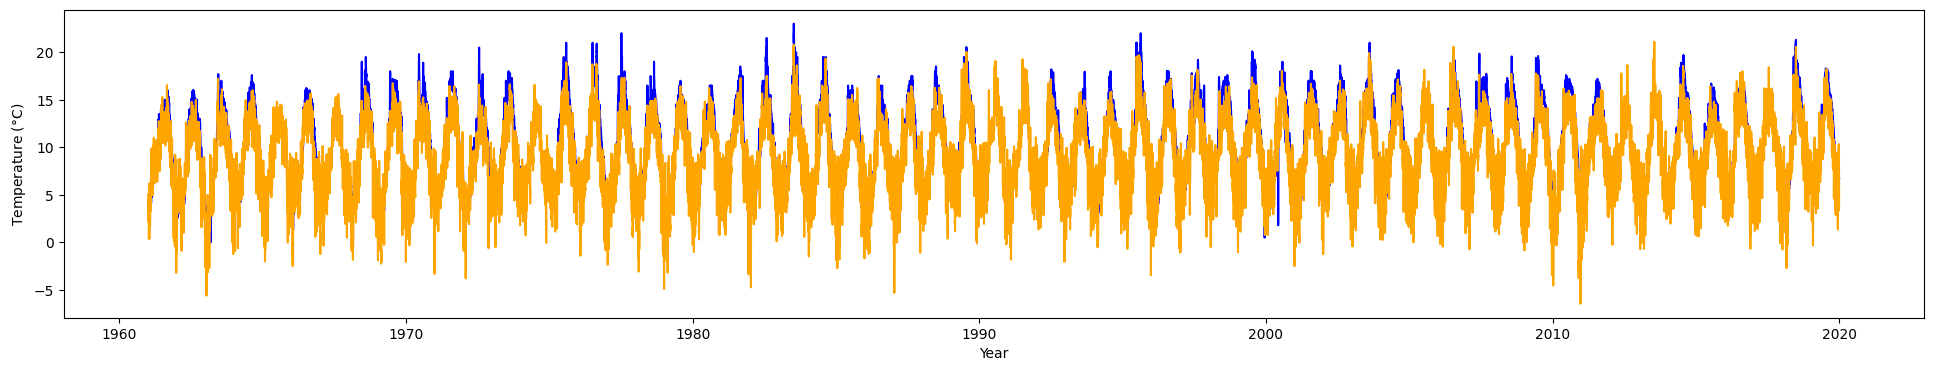

In [14]:
plt.plot(df.date, df.wt, color = 'blue')
plt.plot(df.date, df.tas, color = 'orange')
plt.ylabel(r'Temperature ($\degree$C)')
plt.xlabel('Year')

From the above figure, it seems that the air temperature (orange) is too low in comparison to the water temperature (blue). We analyse this closer in Supplementary Material X, where also look at observational air temperature.  

# Create a cyclic seasonal signal

In [15]:
df['dayofyear'] = df.date.dt.dayofyear # Get the day of year
df = encode(df, 'dayofyear', 365) # Sine cosine encoding of day of year
df.drop('dayofyear', axis = 1, inplace = True) # Drop day of year

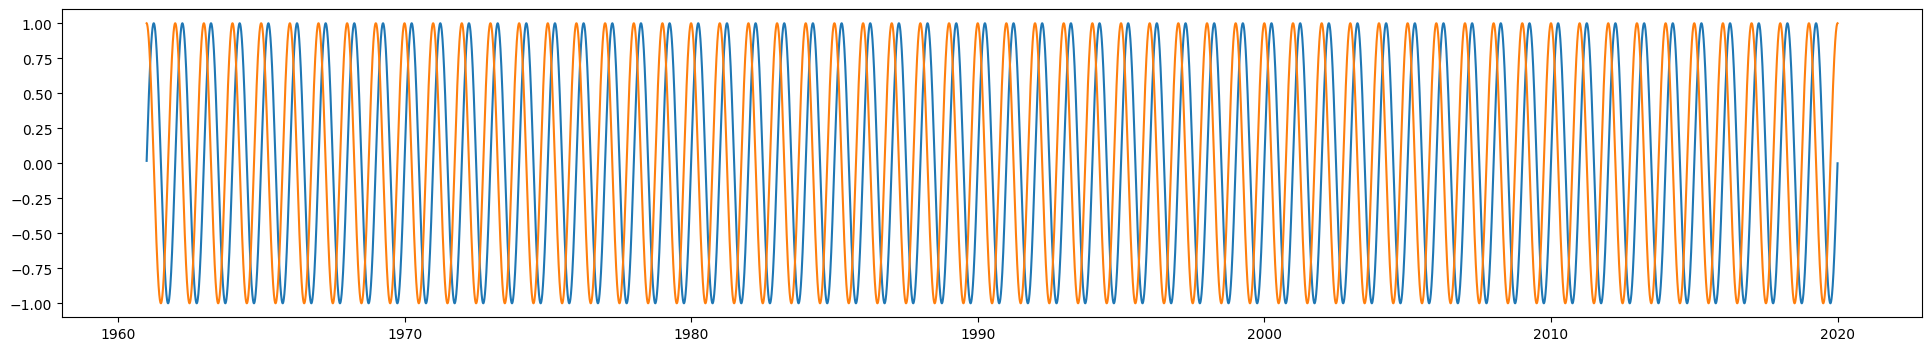

In [16]:
plt.plot(df.date, df.dayofyear_sin)
plt.plot(df.date, df.dayofyear_cos)

This should better the models ability to distinguish seasonal patterns. We use both sine and cosine so that there are no two dates within a year with the exact same combination. 

In [17]:
df = df[df.wt.notna()]

# Split the timeseries into training and validation
We need to match the timeseries training and validation split to the fish observations to maximise their value. 

In [18]:
train_df = df[df['date'].dt.year < 1995] # Set 1961 to, and including, 1994 to training dataset
test_df = df[df['date'].dt.year >= 1995] # Set 1995 to, and including 2019 to testing dataset

x_train = train_df.loc[:, (train_df.columns != 'wt')&(train_df.columns != 'date')] # Remove target/label feature (wt) and date from predictors
y_train = train_df[['wt']] # Get target/label feature (wt) 

x_test = test_df.loc[:, (test_df.columns != 'wt')&(train_df.columns != 'date')] # Remove target/label feature and date from predictors
y_test = test_df[['wt']] # Get target/label feature (wt)

# Pre-process the data (scaling)

In [19]:
x_scalable_cols = x_train.loc[:, (x_train.columns != 'dayofyear_cos')&(x_train.columns != 'dayofyear_sin')].columns # Scale features with exception of seasonal signal

feature_scaler = RobustScaler() # Get robust scaler for features
target_scaler = RobustScaler() # Get robust scaler for target/label
x_scaler = feature_scaler.fit(x_train[x_scalable_cols]) # Fit scaler to feature in training data that need scaling
y_scaler = target_scaler.fit(y_train) # Fit scaler to target/label in training data 

x_train.loc[:, x_scalable_cols] = x_scaler.transform(x_train[x_scalable_cols]) # Perform the scaling on train features 
y_train = y_scaler.transform(y_train) # Perform scaling to train target/label

x_train = pd.DataFrame(x_train, columns = x_train.columns) # Covert to pandas frame to retain headers
y_train = pd.DataFrame(y_train, columns = y_scaler.feature_names_in_) # Convert to pandas frame to retain header

x_test.loc[:, x_scalable_cols] = x_scaler.transform(x_test[x_scalable_cols]) # Use the scaler fit to train data on testing set
y_test = y_scaler.transform(y_test) # Use the scaler fit to train data on testing set

x_test = pd.DataFrame(x_test, columns = x_train.columns) # Convert to pandas frame to retain headers
y_test = pd.DataFrame(y_test, columns = y_scaler.feature_names_in_) # Convert to pandas frame to retain headers

x_train = x_train.fillna(-99) # Give NANs a value that we can mask in the neural network
x_test = x_test.fillna(-99) # Give the NANs a value that we can mask in the neural network

#y_train = y_train.fillna(-99) # Give NANs a value that we can mask in the neural network
#y_test = y_test.fillna(-99) # Give the NANs a value that we can mask in the neural network

C:\Users\adria\AppData\Local\Temp\ipykernel_9204\3461147828.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train.loc[:, x_scalable_cols] = x_scaler.transform(x_train[x_scalable_cols]) # Perform the scaling on train features
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\3461147828.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test.loc[:, x_scalable_cols] = x_scaler.transform(x_test[x_scalable_cols]) # Use the scaler fit to train data on testing set


# Structure the data for the long short-term memory neural network

In [20]:
x_train_array = np.array(x_train) # Set to numpy array for shaping  
y_train_array = np.array(y_train) # Set to numpy array for shaping 

x_test_array = np.array(x_test) # Set to numpy array for shaping
y_test_array = np.array(y_test) # Set to numpy array for shaping

n_past = 365 # Memory (time to accumulate internal state)
n_future = 1 # Days into the future to predict based on memory

lstm_x_train = [] # List to store values 
lstm_y_train = [] # List to store values

lstm_x_test = [] # List to store values
lstm_y_test = [] # List to store values

# Sliding window for loop to generate correct data structure
for i in range(n_past, len(x_train_array) - n_future+1):
    lstm_x_train.append(x_train_array[i - n_past:i, 0:x_train_array.shape[1]])
    lstm_y_train.append(y_train_array[i + n_future -1:i + n_future, 0])

lstm_x_train, lstm_y_train = np.array(lstm_x_train), np.array(lstm_y_train) # Convert to numpy array again

# Repeat for testing datasets
lstm_x_test = []
lstm_y_test = []

for i in range(n_past, len(x_test_array) - n_future+1):
    lstm_x_test.append(x_test_array[i - n_past:i, 0:x_test_array.shape[1]])
    lstm_y_test.append(y_test_array[i + n_future -1:i + n_future, 0])

lstm_x_test, lstm_y_test = np.array(lstm_x_test), np.array(lstm_y_test)    

# Build the long short-term memory neural network

In [21]:
# Define a callback based on validation data to prevent overfitting
callback = keras.callbacks.EarlyStopping(
    monitor = 'val_mean_squared_error',
    patience = 5)

In [22]:
# Defining the long short-term memory neural network

lstm_nn = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value = -99, input_shape = [lstm_x_train.shape[1], lstm_x_train.shape[2]]), # Add masking layer for predefined -99 'NA' indicator
    tf.keras.layers.LSTM(units = 16, return_sequences=False), # Add long short-term memory layer
    tf.keras.layers.Dropout(rate = 0.2), # Freeze random nodes to prevent overfitting (improve generalisability)
    tf.keras.layers.Dense(units = 1) # Add dense linear layer as outputs 
])

lstm_nn.compile(
    optimizer = tf.keras.optimizers.Adam(), # Optimize using Adam
    loss = tf.keras.losses.MeanSquaredError(), # Measure loss as MSE
    metrics = [tf.keras.metrics.MSE] # To monitor validation MSE for callback
)

lstm_nn_history = lstm_nn.fit(x = lstm_x_train, y = lstm_y_train, validation_data=(lstm_x_test, lstm_y_test), callbacks = [callback], epochs = 30) # Fit the neural network on training data, validate on testing data, callback if predictive power on validation isnt improving. Do so in a maximum of 30 epochs.

Epoch 1/30
320/320 [==============================] - 33s 91ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0142 - val_mean_squared_error: 0.0142
Epoch 2/30
320/320 [==============================] - 29s 92ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.0116 - val_mean_squared_error: 0.0116
Epoch 3/30
320/320 [==============================] - 31s 97ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 4/30
320/320 [==============================] - 34s 105ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 5/30
320/320 [==============================] - 34s 105ms/step - loss: 0.0132 - mean_squared_error: 0.0132 - val_loss: 0.0123 - val_mean_squared_error: 0.0123
Epoch 6/30
320/320 [==============================] - 33s 104ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0108 - val_mean_squared_error: 0.0108
Epoch 7/30
32

In [23]:
#lstm_nn_history.model.save(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Models\air_to_water_rnn')


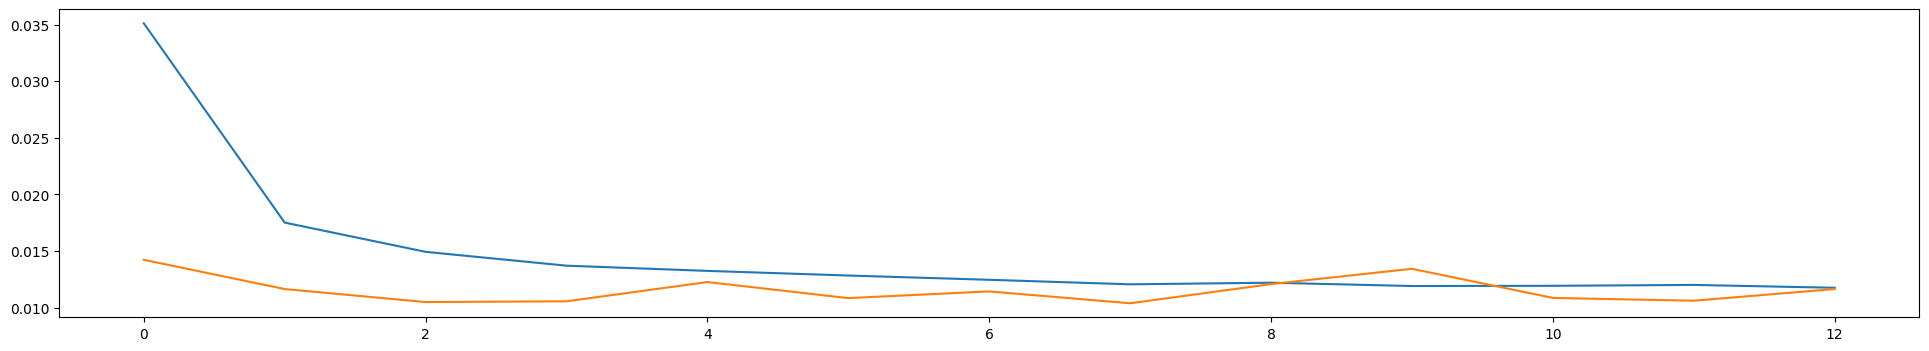

In [24]:
plt.plot(lstm_nn_history.epoch, lstm_nn_history.history['loss'])
plt.plot(lstm_nn_history.epoch, lstm_nn_history.history['val_loss'])

In [25]:
print('The root mean squared error of the long short-term memory neural network on training is', sklearn.metrics.mean_squared_error(train_df.wt[n_past:], y_scaler.inverse_transform(lstm_nn.predict(lstm_x_train).flatten().reshape(-1, 1)), squared = False).round(3), 'in degrees celsius.')
print('The root mean squared error of the long short-term memory neural network on testing is', sklearn.metrics.mean_squared_error(test_df.wt[n_past:], y_scaler.inverse_transform(lstm_nn.predict(lstm_x_test).flatten().reshape(-1, 1)), squared = False).round(3), 'in degrees celsius.')

320/320 [==============================] - 7s 19ms/step
The root mean squared error of the long short-term memory neural network on training is 0.642 in degrees celsius.
228/228 [==============================] - 4s 18ms/step
The root mean squared error of the long short-term memory neural network on testing is 0.863 in degrees celsius.


In [26]:
print('The mean absolute error of the long short-term memory neural network on training is', sklearn.metrics.mean_absolute_error(train_df.wt[n_past:], y_scaler.inverse_transform(lstm_nn.predict(lstm_x_train).flatten().reshape(-1, 1))).round(3), 'in degrees celsius.')
print('The mean absolute error of the long short-term memory neural network on testing is', sklearn.metrics.mean_absolute_error(test_df.wt[n_past:], y_scaler.inverse_transform(lstm_nn.predict(lstm_x_test).flatten().reshape(-1, 1))).round(3), 'in degrees celsius.')

320/320 [==============================] - 6s 19ms/step
The mean absolute error of the long short-term memory neural network on training is 0.473 in degrees celsius.
228/228 [==============================] - 4s 19ms/step
The mean absolute error of the long short-term memory neural network on testing is 0.637 in degrees celsius.


In [27]:
lstm_model = tf.keras.models.load_model(r'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Models\air_to_water_rnn') # This is the model from the paper

# Visualise Model

First we want to use the model on the entire timeseries -> We will recreate the dataframe 

In [28]:
df_full = pd.merge(wt_obs, ds, on = 'date', how = 'inner')
df_full['dayofyear'] = df_full.date.dt.dayofyear
df_full = encode(df_full, 'dayofyear', 365)

x_full = df_full.loc[:, (df_full.columns != 'date')&(df_full.columns != 'dayofyear')&(df_full.columns != 'wt')]
x_full.loc[:, x_scalable_cols] = x_scaler.transform(x_full[x_scalable_cols])
x_full = pd.DataFrame(x_full, columns = x_full.columns)

x_full_array = np.array(x_full)

n_past = 365
n_future = 1

lstm_full = []
for i in range(n_past, len(x_full_array) - n_future+1):
    lstm_full.append(x_full_array[i - n_past:i, 0:x_full_array.shape[1]])

lstm_full = np.array(lstm_full)

df_full['wtp'] = np.nan
df_full['wtp'][n_past:] = y_scaler.inverse_transform(lstm_model.predict(lstm_full)).flatten()

df_full

C:\Users\adria\AppData\Local\Temp\ipykernel_9204\4087676185.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_full.loc[:, x_scalable_cols] = x_scaler.transform(x_full[x_scalable_cols])


662/662 [==============================] - 13s 19ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\4087676185.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['wtp'][n_past:] = y_scaler.inverse_transform(lstm_model.predict(lstm_full)).flatten()


,date,wt,hurs,huss,pr,prsn,rlds,rsds,sfcwind,tas,tasmax,tasmin,dayofyear,dayofyear_sin,dayofyear_cos,wtp
0,1961-01-01,5.0,83.01807,0.004596,0.000105,0.0,294.0871,19.417880,7.283597,4.8588,8.0637,2.6632,1,1.721336e-02,0.999852,NaN
1,1961-01-02,4.9,72.69108,0.003372,0.000091,0.0,262.2524,34.688580,5.998880,2.1800,5.7594,-1.4179,2,3.442161e-02,0.999407,NaN
2,1961-01-03,4.2,76.87292,0.003907,0.000041,0.0,273.4131,30.444470,4.358496,3.4859,5.9880,0.3689,3,5.161967e-02,0.998667,NaN
3,1961-01-04,4.0,82.09290,0.004477,0.000007,0.0,258.8825,30.221140,2.736502,4.7903,7.0894,3.0658,4,6.880243e-02,0.997630,NaN
4,1961-01-05,4.5,84.10378,0.004700,0.000114,0.0,290.6349,26.200130,5.595056,5.0620,6.6710,3.7202,5,8.596480e-02,0.996298,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21544,2019-12-27,6.5,92.50977,0.007288,0.000044,0.0,351.3283,8.306386,7.410038,10.3324,11.3698,9.2445,361,-6.880243e-02,0.997630,5.978017
21545,2019-12-28,6.5,81.79758,0.006077,0.000051,0.0,333.1747,10.530670,8.543204,9.5198,10.6552,8.1850,362,-5.161967e-02,0.998667,6.271645
21546,2019-12-29,6.7,80.66055,0.006228,0.000000,0.0,307.4576,21.702710,8.317272,10.0573,10.7752,8.1113,363,-3.442161e-02,0.999407,6.285390
21547,2019-12-30,6.7,88.61702,0.005801,0.000007,0.0,311.3981,12.112590,4.844712,7.4850,10.2563,3.6317,364,-1.721336e-02,0.999852,6.372072


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


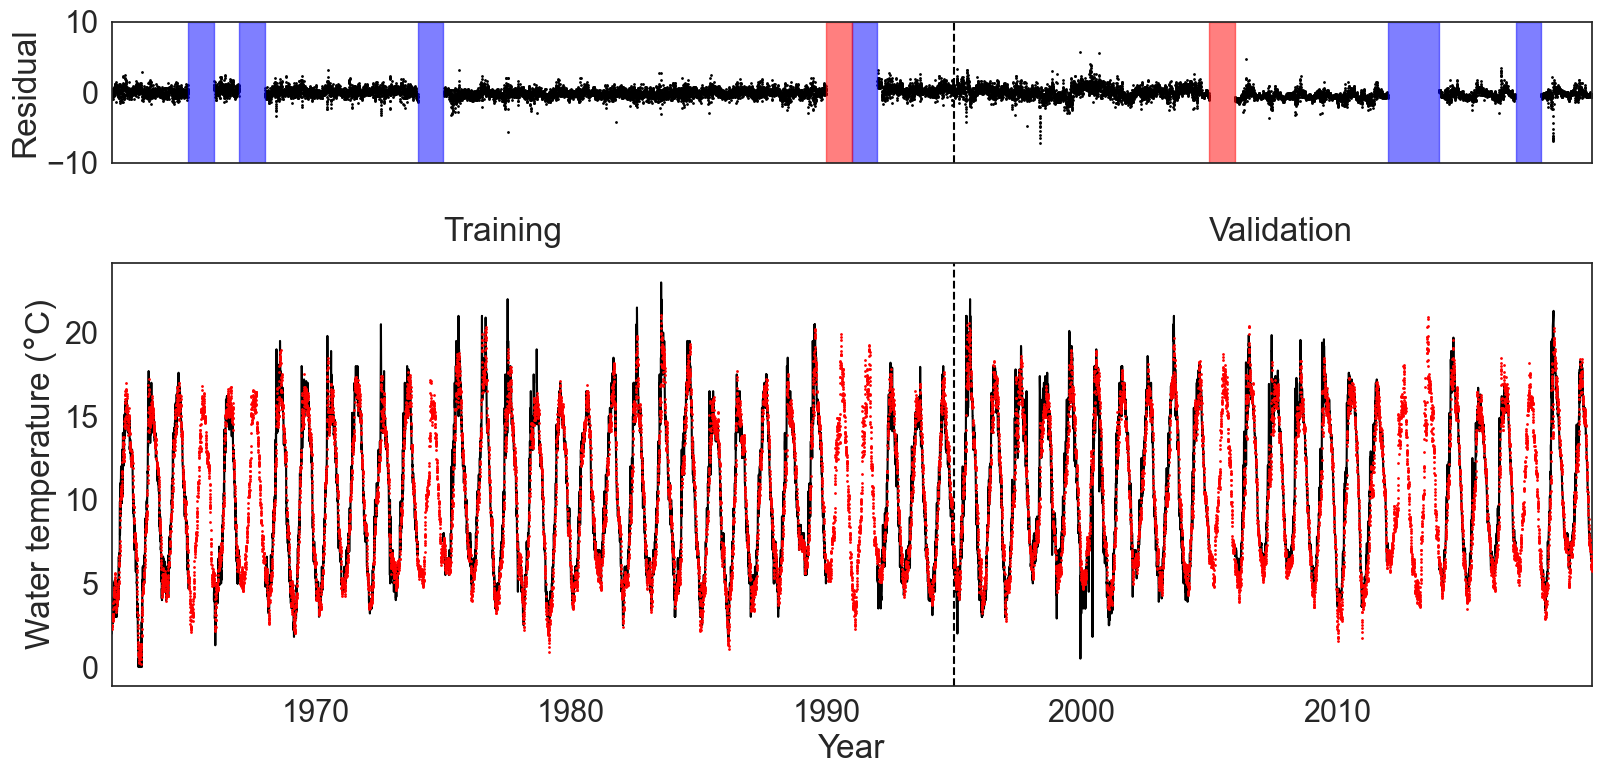

In [29]:
sns.set_theme(style = 'white', font_scale = 2)
f, axs = plt.subplots(2,1,
                      figsize=(8.27*2, 8.27),
                      sharex=True,
                      gridspec_kw=dict(height_ratios=[1,3]))

axs[0].scatter(df_full.date, df_full.wtp-df_full.wt, s = 1, color = 'black')

axs[0].set_ylabel('Residual')
axs[0].set_xlim(dt.date(1962,1,1), dt.date(2019,12,31))
axs[0].set_ylim(-10, 10)
axs[0].axvline(dt.date(1994, 12, 31), color = 'black', linestyle = 'dashed')
axs[0].axvspan(dt.date(1965,1,1), dt.date(1965,12,31), color = 'blue', alpha = 0.5)
axs[0].axvspan(dt.date(1967,1,1), dt.date(1967,12,31), color = 'blue', alpha = 0.5)
axs[0].axvspan(dt.date(1974,1,1), dt.date(1974,12,31), color = 'blue', alpha = 0.5)
axs[0].axvspan(dt.date(1991,1,1), dt.date(1991,12,31), color = 'blue', alpha = 0.5)
axs[0].axvspan(dt.date(2012,1,1), dt.date(2013,12,31), color = 'blue', alpha = 0.5)
axs[0].axvspan(dt.date(2017,1,1), dt.date(2017,12,31), color = 'blue', alpha = 0.5)


axs[0].axvspan(dt.date(1990,1,1), dt.date(1990,12,31), color = 'red', alpha = 0.5)
axs[0].axvspan(dt.date(2005,1,1), dt.date(2005,12,31), color = 'red', alpha = 0.5)

axs[1].plot(wt_obs.date, wt_obs.wt, color = 'black')
axs[1].scatter(df_full.date, df_full.wtp, s = 1, color = 'red', zorder = 100)

axs[1].axvline(dt.date(1994, 12, 31), color = 'black', linestyle = 'dashed')
axs[1].text(x = dt.date(1975, 1, 1), y = 25.5, s = 'Training')
axs[1].text(x = dt.date(2005, 1, 1), y = 25.5, s = 'Validation')

axs[1].set_xlim(dt.date(1962,1,1), dt.date(2019,12,31))

plt.xlabel('Year')
plt.ylabel(r'Water temperature ($\degree$C)')



f.tight_layout()

#plt.savefig('Figures\EPS\Water-Temperature.eps', dpi = 600)
#plt.savefig('Figures\Water-Temperature.tiff', dpi = 600)

In [30]:
df_full

,date,wt,hurs,huss,pr,prsn,rlds,rsds,sfcwind,tas,tasmax,tasmin,dayofyear,dayofyear_sin,dayofyear_cos,wtp
0,1961-01-01,5.0,83.01807,0.004596,0.000105,0.0,294.0871,19.417880,7.283597,4.8588,8.0637,2.6632,1,1.721336e-02,0.999852,NaN
1,1961-01-02,4.9,72.69108,0.003372,0.000091,0.0,262.2524,34.688580,5.998880,2.1800,5.7594,-1.4179,2,3.442161e-02,0.999407,NaN
2,1961-01-03,4.2,76.87292,0.003907,0.000041,0.0,273.4131,30.444470,4.358496,3.4859,5.9880,0.3689,3,5.161967e-02,0.998667,NaN
3,1961-01-04,4.0,82.09290,0.004477,0.000007,0.0,258.8825,30.221140,2.736502,4.7903,7.0894,3.0658,4,6.880243e-02,0.997630,NaN
4,1961-01-05,4.5,84.10378,0.004700,0.000114,0.0,290.6349,26.200130,5.595056,5.0620,6.6710,3.7202,5,8.596480e-02,0.996298,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21544,2019-12-27,6.5,92.50977,0.007288,0.000044,0.0,351.3283,8.306386,7.410038,10.3324,11.3698,9.2445,361,-6.880243e-02,0.997630,5.978017
21545,2019-12-28,6.5,81.79758,0.006077,0.000051,0.0,333.1747,10.530670,8.543204,9.5198,10.6552,8.1850,362,-5.161967e-02,0.998667,6.271645
21546,2019-12-29,6.7,80.66055,0.006228,0.000000,0.0,307.4576,21.702710,8.317272,10.0573,10.7752,8.1113,363,-3.442161e-02,0.999407,6.285390
21547,2019-12-30,6.7,88.61702,0.005801,0.000007,0.0,311.3981,12.112590,4.844712,7.4850,10.2563,3.6317,364,-1.721336e-02,0.999852,6.372072


In [31]:
water_temperature = df_full[['date', 'wt', 'wtp']]
##water_temperature = water_temperature[water_temperature.date.dt.year > 1961]
#water_temperature.columns = ['date', 'wt']
#water_temperature.to_csv(r'Datasets\Simulated\Water_Temperature\Water_Temperature.csv')

In [32]:
year = water_temperature['date'].dt.year
yearly_histcon = water_temperature.groupby([year]).mean().reset_index()
yearly_histcon

year_trend_wt = smf.ols('wt~date', data = yearly_histcon).fit()
year_trend_wt.summary()

C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2904223881.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_histcon = water_temperature.groupby([year]).mean().reset_index()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wt   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     27.97
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           2.99e-06
Time:                        16:59:20   Log-Likelihood:                -36.087
No. Observations:                  50   AIC:                             76.17
Df Residuals:                      48   BIC:                             80.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -35.2502      8.633     -4.083      0.000     -52.608     -17.893
date           0.0229      0.004      5.289      0.000       0.014       0.032
==============================================================================
Omnibus:                        0.109   Durbin-Watson:                   1.697
Prob(Omnibus):                  0.947   Jarque-Bera (JB):                0.312
Skew:                          -0.036   Prob(JB):                        0.856
Kurtosis:                       2.620   Cond. No.                     2.39e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
year_trend_wtp = smf.ols('wtp~date', data = yearly_histcon).fit()
year_trend_wtp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    wtp   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     29.42
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           1.29e-06
Time:                        16:59:20   Log-Likelihood:                -28.790
No. Observations:                  58   AIC:                             61.58
Df Residuals:                      56   BIC:                             65.70
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -23.9395      6.316     -3.790      0.000     -36.592     -11.287
date           0.0172      0.003      5.424      0.000       0.011       0.024
==============================================================================
Omnibus:                        0.735   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.692   Jarque-Bera (JB):                0.591
Skew:                          -0.243   Prob(JB):                        0.744
Kurtosis:                       2.910   Cond. No.                     2.37e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
print(summary_col([year_trend_wt, year_trend_wtp], stars=True,float_format='%0.3f'))


                   wt        wtp    
------------------------------------
Intercept      -35.250*** -23.940***
               (8.633)    (6.316)   
date           0.023***   0.017***  
               (0.004)    (0.003)   
R-squared      0.368      0.344     
R-squared Adj. 0.355      0.333     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# Forecast

In [35]:
climate_forcings = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll'] # Store climate forcings in list
climate_scenarios = ['ssp126', 'ssp370', 'ssp585']
climate_variables = ['tas','tasmax', 'tasmin', 'pr', 'prsn', 'huss', 'hurs', 'rsds', 'rlds', 'sfcwind'] # Store abbreviations in list

In [36]:
fds = pd.DataFrame()

for climate_forcing in climate_forcings:
    for climate_scenario in climate_scenarios:
        for climate_variable in climate_variables:
            if climate_variable in ['tas', 'tasmax', 'tasmin']:
                ds_var = read_multiple_csv(rf'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\ISIMIP3b\{climate_forcing}\{climate_scenario}\{climate_variable}', 'date', 'value', transform_func = kelvinToCelsius)
                ds_var['climate_forcing'] = climate_forcing
                ds_var['climate_scenario'] = climate_scenario
                ds_var['climate_variable'] = climate_variable
                fds = pd.concat([fds, ds_var])
            elif climate_variable in ['pr', 'prsn', 'sfcwind']:
                ds_var = read_multiple_csv(rf'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\ISIMIP3b\{climate_forcing}\{climate_scenario}\{climate_variable}', 'date', 'value', transform_func = None)
                ds_var['climate_forcing'] = climate_forcing
                ds_var['climate_scenario'] = climate_scenario
                ds_var['climate_variable'] = climate_variable
                fds = pd.concat([fds, ds_var])
            elif climate_variable in ['huss', 'hurs', 'rsds', 'rlds']:
                ds_var = read_multiple_csv(rf'C:\Users\adria\Desktop\Growth_of_juvenile_Atlantic_salmon_Reproducible_code\Datasets\Simulated\ISIMIP3b\{climate_forcing}\{climate_scenario}\{climate_variable}', 'date', 'value', transform_func = None)
                ds_var['climate_forcing'] = climate_forcing
                ds_var['climate_scenario'] = climate_scenario
                ds_var['climate_variable'] = climate_variable
                fds = pd.concat([fds, ds_var])


fds['date'] = pd.to_datetime(fds['date'], errors = 'coerce')
fds = fds[fds.date.notna()]
fds = fds[fds.date.dt.year > 1960].reset_index(drop = True)

In [37]:
fdf = pd.DataFrame()
df_long = pd.DataFrame()

for climate_forcing in climate_forcings:
    for climate_scenario in climate_scenarios:
        if climate_scenario in ['ssp126', 'ssp370', 'ssp585']:
            df_long = fds[(fds['climate_forcing'] == climate_forcing)&(fds['climate_scenario'] == climate_scenario)]
            df_long['climate_scenario'] = climate_scenario
            fdf = pd.concat([fdf, df_long])


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\3825661660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['climate_scenario'] = climate_scenario
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\3825661660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_long['climate_scenario'] = climate_scenario
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\3825661660.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [38]:
forecast = pd.DataFrame()

for climate_forcing in climate_forcings:
    for climate_scenario in climate_scenarios:
        test = fdf[(fdf['climate_forcing'] == climate_forcing)&(fdf['climate_scenario'] == climate_scenario)].pivot(index = 'date', columns = 'climate_variable', values = 'value')
        test.index = pd.to_datetime(test.index)
        test.reset_index(inplace = True)
        test['dayofyear'] = test.date.dt.dayofyear
        test = encode(test, 'dayofyear', 365)
        test.drop('dayofyear', axis = 1, inplace = True)
        x_future = test.loc[:, (test.columns != 'date')] # Remove target/label and date feature from predictors
        x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features 
        x_future = pd.DataFrame(x_future, columns = x_future.columns) # Covert to pandas frame to retain headers
        x_future = x_future.fillna(-99) # Give NANs a value that we can mask in the neural network
        x_future_array = np.array(x_future) # Set to numpy array for shaping  
        n_past = 365 # Memory (time to accumulate internal state)
        n_future = 1 # Days into the future to predict based on memory
        lstm_x_future = [] # List to store values 
        # Sliding window for loop to generate correct data structure
        for i in range(n_past, len(x_future_array) - n_future+1):
            lstm_x_future.append(x_future_array[i - n_past:i, 0:x_future_array.shape[1]])
        lstm_x_future = np.array(lstm_x_future) # Convert to numpy array again
        test['wt'] = np.nan
        test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
        test['climate_forcing'] = climate_forcing
        test['climate_scenario'] = climate_scenario
        test = test[['date', 'wt', 'climate_forcing', 'climate_scenario']]
        forecast = pd.concat([forecast, test])


forecast


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 20s 19ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 22s 23ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 23s 24ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 19s 20ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 19s 19ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 21s 22ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 21s 22ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 22s 22ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 21s 22ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 21s 22ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 21s 22ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 18s 19ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 17s 18ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 19s 20ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()
C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_future.loc[:, x_scalable_cols] = x_scaler.transform(x_future[x_scalable_cols]) # Perform the scaling on train features


971/971 [==============================] - 19s 19ms/step


C:\Users\adria\AppData\Local\Temp\ipykernel_9204\2401727363.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['wt'][n_past:] = target_scaler.inverse_transform(lstm_model.predict(lstm_x_future)).flatten()


climate_variable,date,wt,climate_forcing,climate_scenario
0,2015-01-01,NaN,gfdl-esm4,ssp126
1,2015-01-02,NaN,gfdl-esm4,ssp126
2,2015-01-03,NaN,gfdl-esm4,ssp126
3,2015-01-04,NaN,gfdl-esm4,ssp126
4,2015-01-05,NaN,gfdl-esm4,ssp126
...,...,...,...,...
31406,2100-12-27,8.178436,ukesm1-0-ll,ssp585
31407,2100-12-28,8.593669,ukesm1-0-ll,ssp585
31408,2100-12-29,8.821732,ukesm1-0-ll,ssp585
31409,2100-12-30,8.947570,ukesm1-0-ll,ssp585


In [39]:
#from datetime import date
#today = date.today()
#forecast.to_csv(rf'Datasets\Simulated\Water_Temperature\Water_Temperature_Forecast_{today}.csv', index = False)

In [40]:
ensemble_forecast = forecast.groupby(['date', 'climate_scenario']).mean().reset_index()
ensemble_forecast = ensemble_forecast[ensemble_forecast.date.dt.year > 2019]
ensemble_forecast

C:\Users\adria\AppData\Local\Temp\ipykernel_9204\527497105.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ensemble_forecast = forecast.groupby(['date', 'climate_scenario']).mean().reset_index()


climate_variable,date,climate_scenario,wt
5478,2020-01-01,ssp126,5.951082
5479,2020-01-01,ssp370,5.642460
5480,2020-01-01,ssp585,5.343469
5481,2020-01-02,ssp126,5.769651
5482,2020-01-02,ssp370,5.451282
...,...,...,...
94228,2100-12-30,ssp370,7.130052
94229,2100-12-30,ssp585,7.786684
94230,2100-12-31,ssp126,6.537752
94231,2100-12-31,ssp370,7.131276


# Quantify RCP Trends

In [41]:
year = ensemble_forecast['date'].dt.year
decade = ensemble_forecast['date'].dt.year.floordiv(10).mul(10)

yearly_forecast = ensemble_forecast.groupby([year, 'climate_scenario'])['wt'].mean().reset_index()
decadal_forecast = ensemble_forecast.groupby([decade, 'climate_scenario'])['wt'].mean().reset_index()

In [42]:
year_trend = smf.ols('wt~date*climate_scenario-1', data = yearly_forecast).fit()
year_trend.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     wt   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     404.0
Date:                Wed, 07 Jun 2023   Prob (F-statistic):          8.72e-114
Time:                        17:05:22   Log-Likelihood:                 52.997
No. Observations:                 243   AIC:                            -93.99
Df Residuals:                     237   BIC:                            -73.04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
climate_scenario[ssp126]           13.8533      1.929      7.183      0.000      10.054      17.653
climate_scenario[ssp370]          -27.1635      1.929    -14.084      0.000     -30.963     -23.364
climate_scenario[ssp585]          -45.6667      1.929    -23.677      0.000     -49.466     -41.867
date                               -0.0014      0.001     -1.503      0.134      -0.003       0.000
date:climate_scenario[T.ssp370]     0.0202      0.001     15.252      0.000       0.018       0.023
date:climate_scenario[T.ssp585]     0.0293      0.001     22.120      0.000       0.027       0.032
==============================================================================
Omnibus:                        1.000   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.606   Jarque-Bera (JB):                0.786
Skew:                          -0.131   Prob(JB):                        0.675
Kurtosis:                       3.094   Cond. No.                     3.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
print(summary_col(year_trend, stars=True,float_format='%0.2f'))


                                    wt   
-----------------------------------------
climate_scenario[ssp126]        13.85*** 
                                (1.93)   
climate_scenario[ssp370]        -27.16***
                                (1.93)   
climate_scenario[ssp585]        -45.67***
                                (1.93)   
date                            -0.00    
                                (0.00)   
date:climate_scenario[T.ssp370] 0.02***  
                                (0.00)   
date:climate_scenario[T.ssp585] 0.03***  
                                (0.00)   
R-squared                       0.89     
R-squared Adj.                  0.89     
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# Visualising within-year variation on a decadal temporal resolution

In [44]:
year = ensemble_forecast['date'].dt.year
decade = ensemble_forecast['date'].dt.year.floordiv(10).mul(10)
ensemble_forecast['dayofyear'] = ensemble_forecast.date.dt.dayofyear
within_variation = ensemble_forecast.groupby([year, 'climate_scenario', 'dayofyear'])['wt'].mean().reset_index()
within_variation

,date,climate_scenario,dayofyear,wt
0,2020,ssp126,1,5.951082
1,2020,ssp126,2,5.769651
2,2020,ssp126,3,5.620692
3,2020,ssp126,4,5.407966
4,2020,ssp126,5,5.262347
...,...,...,...,...
88750,2100,ssp585,361,7.863723
88751,2100,ssp585,362,7.885791
88752,2100,ssp585,363,7.812339
88753,2100,ssp585,364,7.786684


In [45]:
within_variation = within_variation.rename({'climate_scenario': 'Climate Scenario'}, axis  = 1)
within_variation['Climate Scenario'].replace('ssp126', 'SSP1-RCP2.6', inplace = True)
within_variation['Climate Scenario'].replace('ssp370', 'SSP3-RCP7.0', inplace = True)
within_variation['Climate Scenario'].replace('ssp585', 'SSP5-RCP8.5', inplace = True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


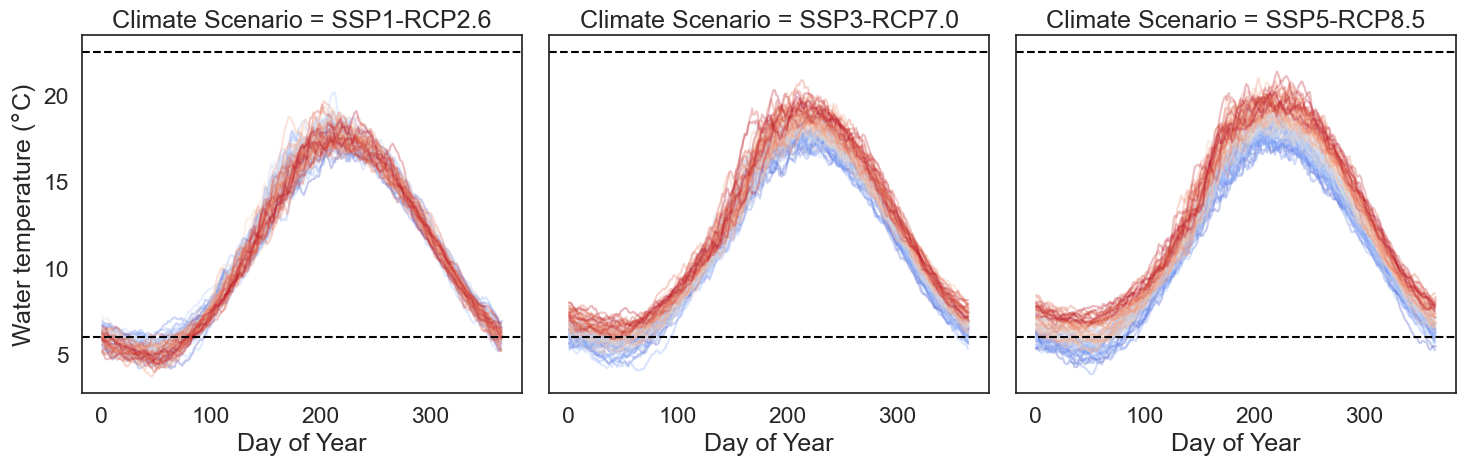

In [46]:
sns.set_theme(style = 'white', font_scale = 1.5)
g = sns.relplot(data = within_variation, kind = 'line', col = 'Climate Scenario', col_wrap = 3, x = 'dayofyear', y = 'wt', hue = 'date', estimator = None, legend = None, alpha = 0.3, palette = sns.color_palette('coolwarm', as_cmap = True))
(g.map(plt.axhline, y = 22.51, linestyle = 'dashed', color = 'black')
    .set_axis_labels('Day of Year', r'Water temperature ($\degree$C)'))
(g.map(plt.axhline, y = 5.99, linestyle = 'dashed', color = 'black'))
#.figure.colorbar(sm, location = 'bottom', use_gridspec = False)
sns.despine(fig = g, right = False, top = False)

#plt.savefig('Figures\EPS\Future-Water-Temperature.eps', dpi = 600)
#plt.savefig('Figures\Future-Water-Temperature.tiff', dpi = 600)

# Time spent within growth temperatures

In [47]:
years = []
proportion = []
cs = []
ensemble_forecast['year'] = ensemble_forecast.date.dt.year
for climate_scenario in ensemble_forecast.climate_scenario.unique():
    for year in ensemble_forecast.year.unique():
        years.append(year)
        cs.append(climate_scenario)
        proportion.append(len(ensemble_forecast[(ensemble_forecast['climate_scenario'] == climate_scenario)&(ensemble_forecast['year'] == year)&(ensemble_forecast['wt'] >= 6)&(ensemble_forecast['wt'] <= 22.51)]) / len(ensemble_forecast[(ensemble_forecast['climate_scenario'] == climate_scenario)&(ensemble_forecast['year'] == year)]))

In [48]:
thermal_niche = pd.DataFrame({'Year': years, 'Proportion': proportion, 'climate_scenario': cs})
thermal_niche['Percent'] = thermal_niche.Proportion*100

In [49]:
time_spent = smf.ols('Percent~Year*climate_scenario', data = thermal_niche).fit()
time_spent.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Percent   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     100.9
Date:                Wed, 07 Jun 2023   Prob (F-statistic):           1.11e-56
Time:                        17:05:28   Log-Likelihood:                -734.79
No. Observations:                 243   AIC:                             1482.
Df Residuals:                     237   BIC:                             1503.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                         184.1138     49.341      3.731      0.000      86.910     281.317
climate_scenario[T.ssp370]       -604.5506     69.779     -8.664      0.000    -742.017    -467.084
climate_scenario[T.ssp585]       -691.8976     69.779     -9.916      0.000    -829.364    -554.431
Year                               -0.0502      0.024     -2.096      0.037      -0.097      -0.003
Year:climate_scenario[T.ssp370]     0.2988      0.034      8.823      0.000       0.232       0.366
Year:climate_scenario[T.ssp585]     0.3409      0.034     10.065      0.000       0.274       0.408
==============================================================================
Omnibus:                        5.842   Durbin-Watson:                   1.837
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                6.405
Skew:                           0.237   Prob(JB):                       0.0407
Kurtosis:                       3.638   Cond. No.                     6.77e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""